In [1]:
from PIL import Image
import numpy as np
import cupy as cp
from scipy.ndimage import convolve1d
from matplotlib import pyplot, cm
from IPython.display import display

In [2]:
def compute_coordinates(res, size):
    """Return an array of shape (res) containing the coordinates of a sampling lattice."""
    pitch = size / res
    indices = cp.arange(res)
    return (-size/2 + pitch/2) + indices * pitch

def compute_intervals(res, size):
    """Return an array of shape (res+1) containing the boundaries of each sampling cell."""
    pitch = size / res
    indices = cp.arange(res+1)
    return (-size/2) + indices * pitch

def ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f):
    """Return the coordinates on the retina corresponding to the given coordinates on planes A and B."""
    return (x_b * (1.0 - z_a/z_f) - x_a * (1.0 - z_b/z_f)) * (z_r / (z_b - z_a))

def ra_to_p(x_r, x_a, z_r, z_a, z_f):
    """Return the coordinates on the pupil corresponding to the given coordinates on plane A and the retina."""
    return (x_a - x_r * (z_a/z_r)) * np.reciprocal(1.0 - z_a/z_f)

def compute_imaging_tensor(x_r, ivl_a, ivl_b, z_r, z_a, z_b, z_f, pupil_diameter):
    """Return the flatland imaging tensor."""
    # Project intervals to the pupil
    ivl_a_at_p = ra_to_p(x_r, ivl_a, z_r, z_a, z_f)
    ivl_b_at_p = ra_to_p(x_r, ivl_b, z_r, z_b, z_f)
    # Bounds imposed by the pupil aperture
    lower_bound = -pupil_diameter/2
    upper_bound =  pupil_diameter/2
    # Restrict plane A intervals to the pupil aperture
    ivl_pa = cp.clip(ivl_a_at_p, -pupil_diameter/2, pupil_diameter/2)
    # Bounds imposed by the pupil aperture and plane A intervals together
    lower_bound = cp.minimum(ivl_pa[..., :-1, :], ivl_pa[..., 1:, :])
    upper_bound = cp.maximum(ivl_pa[..., :-1, :], ivl_pa[..., 1:, :])
    # Restrict plane B intervals to the pupil aperture and plane A intervals
    ivl_pab = cp.clip(ivl_b_at_p, lower_bound, upper_bound)
    # Bounds imposed by the pupil aperture, plane A intervals and plane B intervals together
    lower_bound = cp.minimum(ivl_pab[..., :-1], ivl_pab[..., 1:])
    upper_bound = cp.maximum(ivl_pab[..., :-1], ivl_pab[..., 1:])
    # Return the lengths of the intervals
    return cp.subtract(upper_bound, lower_bound)

def compute_upscale_matrix(res, upscale_factor):
    """Return a sinc interpolating upscale matrix."""
    low_res_samples = compute_coordinates(res, res)
    high_res_samples = compute_coordinates(res * upscale_factor, res)
    return cp.sinc(high_res_samples[..., np.newaxis] - low_res_samples)

def cosine_signal(x, frequency, phase=0.0):
    """Sample a cosine with given frequency and phase at given sampling coordinates."""
    return cp.cos((x * frequency + phase) * 2 * np.pi)/2 + 0.5

def display_image(values, color_map=None):
    """Display an array of values as an image using a color map."""
    color_values = cm.get_cmap(color_map)(values/np.amax(values))
    uint8_values = (color_values * 255).astype(np.uint8)
    display(Image.fromarray(uint8_values).transpose(Image.ROTATE_90))

In [3]:
z_r = 17.0
z_a =  6.5
z_b = 15.5


pupil_diameter = 5.0

size_r = 5.5
size_a = size_r * z_a / z_r + pupil_diameter
size_b = size_r * z_b / z_r + pupil_diameter


res_r = 1024
res_a = 64
res_b = 64


xi_r = 2.5
xi_a = 0.5 * res_a / size_a
xi_b = 0.5 * res_b / size_b


hit_a = (z_r * xi_r - z_b * xi_b) / z_a
hit_b = (z_r * xi_r - z_a * xi_a) / z_b
z_near = z_r * xi_r / (xi_a + hit_b)
z_far  = z_r * xi_r / (hit_a + xi_b)
z_opt = (z_a * xi_a + z_b * xi_b) / (xi_a + xi_b)

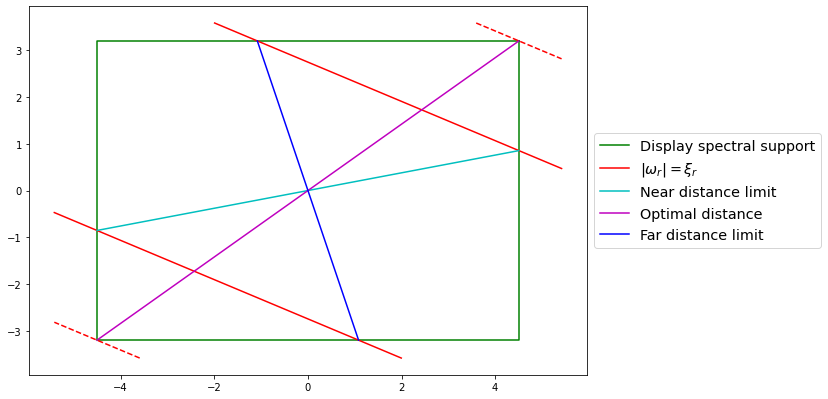

In [4]:
fig, ax = pyplot.subplots(figsize=(10, 10))

ax.plot([xi_a,  xi_a, -xi_a, -xi_a, xi_a], [xi_b, -xi_b, -xi_b,  xi_b, xi_b], 'g', label='Display spectral support')

ax.plot([ hit_a-z_b/z_r,  xi_a+z_b/z_r], [ xi_b+z_a/z_r,  hit_b-z_a/z_r], 'r', label=r'$|\omega_r| = \xi_r$')
ax.plot([-hit_a+z_b/z_r, -xi_a-z_b/z_r], [-xi_b-z_a/z_r, -hit_b+z_a/z_r], 'r')
ax.plot([ xi_a-z_b/z_r,  xi_a+z_b/z_r], [ xi_b+z_a/z_r,  xi_b-z_a/z_r], 'r--')
ax.plot([-xi_a+z_b/z_r, -xi_a-z_b/z_r], [-xi_b-z_a/z_r, -xi_b+z_a/z_r], 'r--')

ax.plot([-xi_a, xi_a], [-hit_b, hit_b], 'c', label='Near distance limit')
ax.plot([-xi_a, xi_a], [-xi_b, xi_b], 'm', label='Optimal distance')
ax.plot([-hit_a, hit_a], [-xi_b, xi_b], 'b', label='Far distance limit')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='x-large')
ax.set_aspect('equal')

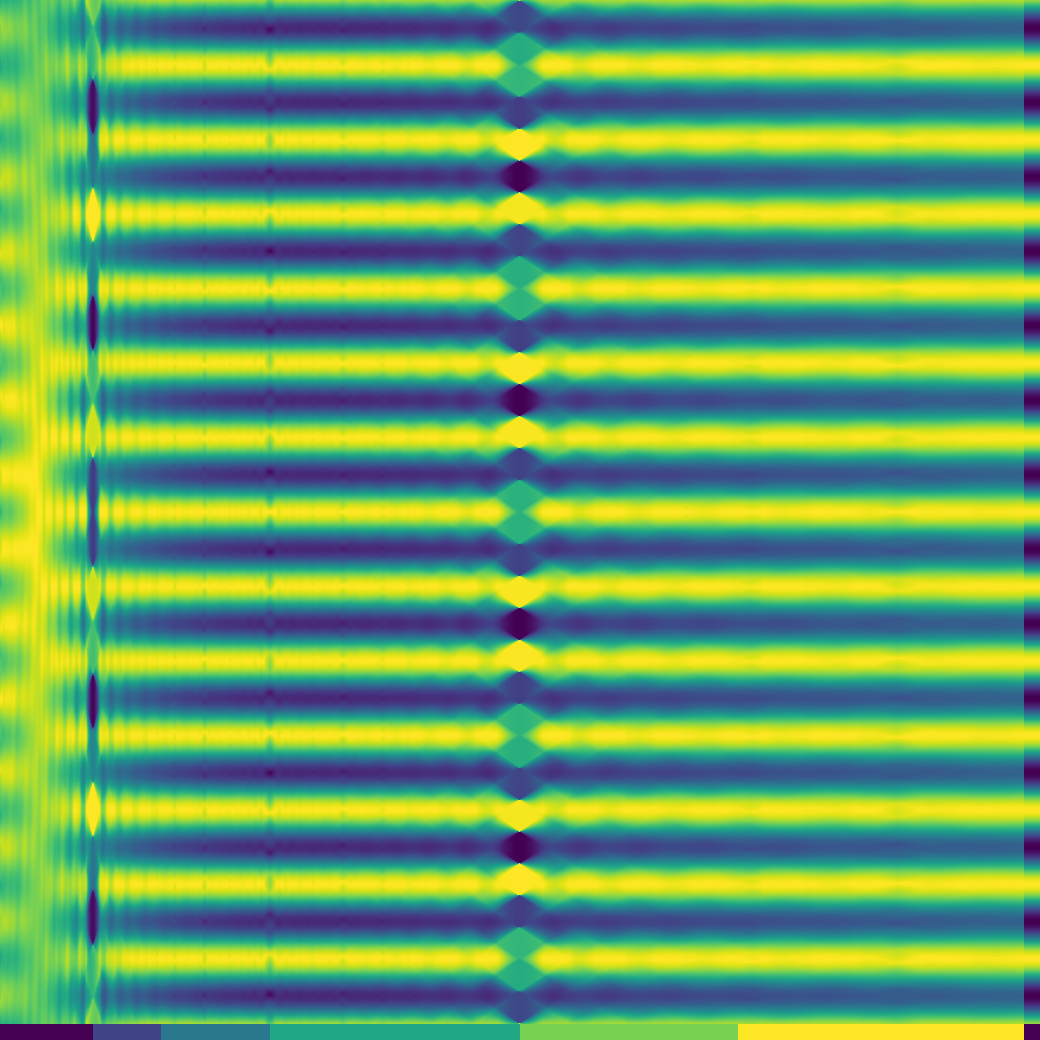

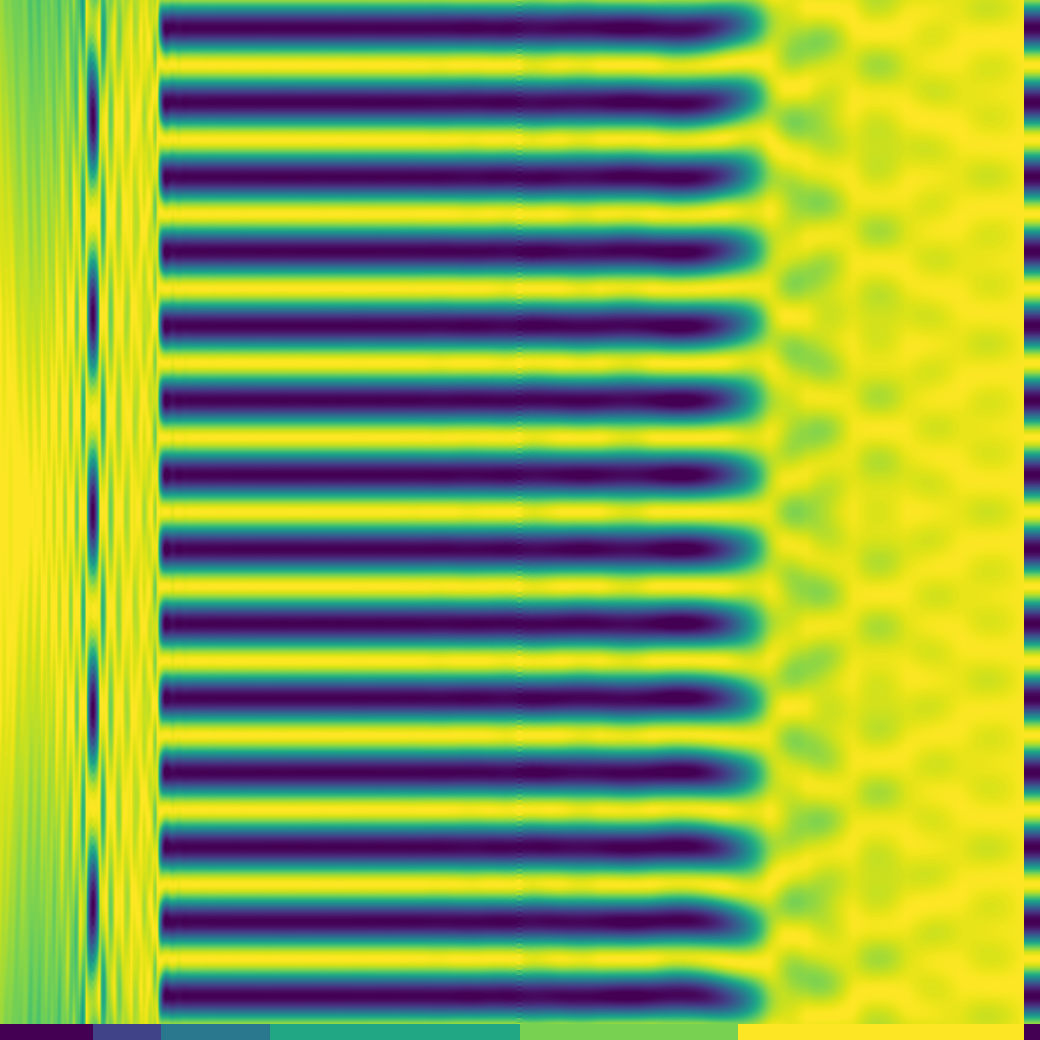

In [5]:
upscale_factor = 6

x_r = compute_coordinates(res_r, size_r)[    ::    , np.newaxis, np.newaxis]
x_a = compute_coordinates(res_a, size_a)[np.newaxis,     ::    , np.newaxis]
x_b = compute_coordinates(res_b, size_b)[np.newaxis, np.newaxis,     ::    ]

ivl_a = compute_intervals(res_a * upscale_factor, size_a)[np.newaxis,     ::    , np.newaxis]
ivl_b = compute_intervals(res_b * upscale_factor, size_b)[np.newaxis, np.newaxis,     ::    ]

upscale_matrix = compute_upscale_matrix(res_a, upscale_factor)

res_f = 1024
block_f = 1

bar_size = 16

result_box = np.zeros((res_f + bar_size, res_r + bar_size))
result_sinc = np.zeros((res_f + bar_size, res_r + bar_size))

z_f = cp.linspace(z_a*0.7, z_far*1.3, res_f)[     ::    , np.newaxis, np.newaxis, np.newaxis]

for i in range(res_f//block_f):
    slice_f = slice(i*block_f, (i+1)*block_f)
    x_ab_at_r = ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f[slice_f])
    s_ab = cosine_signal(x_ab_at_r, xi_r)
    s_ab_box = cp.repeat(cp.repeat(s_ab, upscale_factor, axis=-1), upscale_factor, axis=-2)
    s_ab_sinc = cp.tensordot(cp.tensordot(s_ab, upscale_matrix, axes=(-2,-1)), upscale_matrix, axes=(-2,-1))
    img_tsr = compute_imaging_tensor(x_r, ivl_a, ivl_b, z_r, z_a, z_b, z_f[slice_f], pupil_diameter)
    s_ab_box_at_r = cp.sum(img_tsr * s_ab_box, axis=(-2, -1))
    s_ab_sinc_at_r = cp.sum(img_tsr * s_ab_sinc, axis=(-2, -1))
    result_box[slice_f, bar_size:] = (s_ab_box_at_r/cp.amax(s_ab_box_at_r, axis=1, keepdims=True)).get()
    result_sinc[slice_f, bar_size:] = (s_ab_sinc_at_r/cp.amax(s_ab_sinc_at_r, axis=1, keepdims=True)).get()

z_color = (z_f > z_a)*0.2 + (z_f > z_near)*0.2 + (z_f > z_opt)*0.2 + (z_f > z_b)*0.2 + (z_f > z_far)*0.2
result_box[:-bar_size, :bar_size] = z_color[..., 0, 0].get()
result_sinc[:-bar_size, :bar_size] = result_box[:-bar_size, :bar_size]
result_box[-bar_size:, bar_size:] = cosine_signal(x_r, xi_r)[..., 0, 0].get()
result_sinc[-bar_size:, bar_size:] = result_box[-bar_size:, bar_size:]

display_image(result_box)
display_image(result_sinc)